# Combined search

In [2]:
# in order to run on all CPUs
import os
import jax

jax.config.update("jax_enable_x64", True)
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

In this notebook we use nuance to search for periodic transits in combined datasets, that might originate from different instruments or sparse observations. 

## Generating the data

We start by simulating two datasets with different exposures, systematics and noise models, and with a partial overlap.

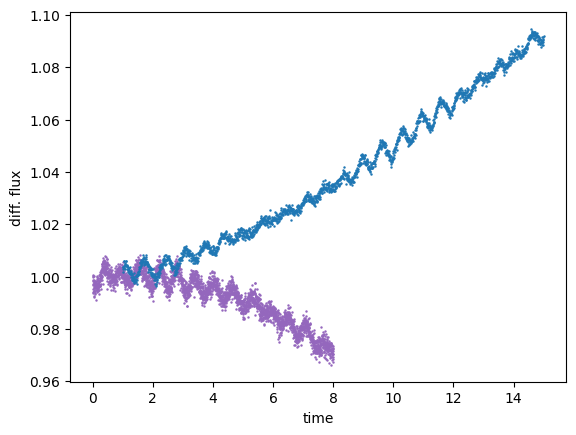

In [3]:
import numpy as np
from nuance import core
import matplotlib.pyplot as plt
from tinygp import kernels, GaussianProcess


depth = 8e-4
times = {
    0: np.linspace(0.0, 8.0, 3000),
    1: np.linspace(1.0, 15.0, 2000),
}

transit_prams = {"epoch": 0.2, "duration": 0.05, "period": 0.75}
kernel = kernels.quasisep.SHO(10.0, 10.0, 0.002)

data = {
    0: {
        "gp": GaussianProcess(kernel, times[0], diag=0.002**2),
        "X": np.vander(times[0], N=4, increasing=True).T,
        "w": np.array([1.0, 10e-4, -5e-4, -0.1e-4]),
    },
    1: {
        "gp": GaussianProcess(kernel, times[1], diag=0.001**2),
        "X": np.vander(times[1], N=4, increasing=True).T,
        "w": np.array([1.0, 10e-4, 5e-4, -0.1e-4]),
    },
}

for key, values in data.items():
    true_transit = depth * core.transit(times[key], **transit_prams)
    flux = (
        values["gp"].sample(jax.random.PRNGKey(40))
        + true_transit
        + values["w"] @ values["X"]
    )
    data[key]["flux"] = flux
    data[key]["time"] = times[key]


plt.plot(data[0]["time"], data[0]["flux"], ".", ms=1.5, c="C4")
plt.plot(data[1]["time"], data[1]["flux"], ".", ms=1.5, c="C0")
plt.ylabel("diff. flux")
_ = plt.xlabel("time")

We start by performing the [`linear_search`](nuance.linear_search) on both datasets separately

In [4]:
from nuance.linear_search import linear_search

epochs = data[0]["time"].copy()
durations = np.linspace(0.01, 0.2, 15)

ls_0 = linear_search(
    data[0]["time"], data[0]["flux"], X=data[0]["X"], gp=data[0]["gp"]
)(epochs, durations)
ls_1 = linear_search(
    data[1]["time"], data[1]["flux"], X=data[1]["X"], gp=data[1]["gp"]
)(epochs, durations)

100%|██████████| 3010/3010 [00:00<00:00, 3475.02it/s]


We then combine the [`linear_search`](nuance.linear_search) results of these two datasets

In [13]:
from nuance.linear_search import combine_linear_searches

ls = combine_linear_searches(ls_0, ls_1)

and perform the linear search

In [14]:
from nuance import core
from nuance.periodic_search import periodic_search

periods = np.linspace(0.1, 2.0, 2000)

snr_function = jax.jit(
    core.snr(
        [v["time"] for v in data.values()],
        [v["flux"] for v in data.values()],
        gp=[v["gp"] for v in data.values()],
        X=[v["X"] for v in data.values()],
    )
)
ps_function = periodic_search(epochs, durations, ls, snr_function)
snr, params = ps_function(periods)

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2000/2000 [00:01<00:00, 1626.01it/s]


Before plotting the transit SNR periodogram, let's perform a [`periodic_search`](nuance.periodic_search) on each dataset individually

In [10]:
snr_function = jax.jit(
    core.snr(data[0]["time"], data[0]["flux"], X=data[0]["X"], gp=data[0]["gp"])
)
ps_function = periodic_search(epochs, durations, ls_0, snr_function)
snr_0, params = ps_function(periods)

snr_function = jax.jit(
    core.snr(data[1]["time"], data[1]["flux"], X=data[1]["X"], gp=data[1]["gp"])
)
ps_function = periodic_search(epochs, durations, ls_1, snr_function)
snr_1, params = ps_function(periods)

/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2000/2000 [00:00<00:00, 3024.26it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/nuance/lib/python3.10/site-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 2000/2000 [00:00<00:00, 3542.31it/s]


and finally, plot the results

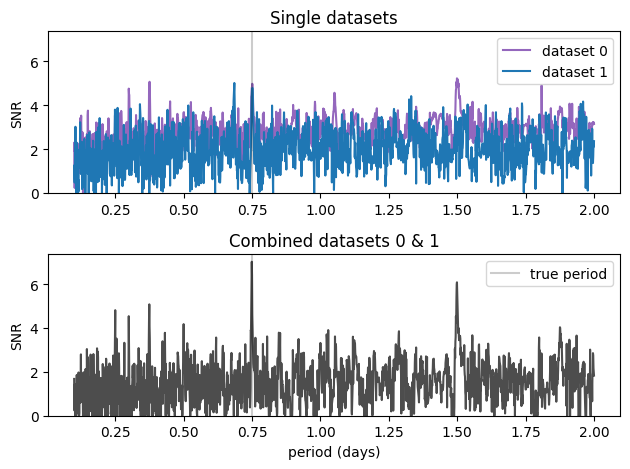

In [12]:
plt.subplot(212)
plt.plot(periods, snr, c="0.3")
plt.ylim(
    0,
)
ylim = plt.ylim()
plt.axvline(transit_prams["period"], color="k", alpha=0.2, label="true period")
plt.ylabel("SNR")
plt.xlabel("period (days)")
plt.title("Combined datasets 0 & 1")
plt.legend()

plt.subplot(211)
plt.plot(periods, snr_0, c="C4", label="dataset 0")
plt.plot(periods, snr_1, c="C0", label="dataset 1")
plt.axvline(transit_prams["period"], color="k", alpha=0.2)
plt.ylabel("SNR")
plt.title("Single datasets")
plt.ylim(ylim)
plt.legend()

plt.tight_layout()

As excepted, combining datasets leads to a higher SNR transit detection.